In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
sentTrain = pd.read_csv('generic_sentiment_dataset_50k.csv')
display(sentTrain.head())
display(sentTrain.shape)

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,2
1,positive,Overall in hand ecpirience is quite good matt ...,2
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",2
3,positive,Bigger size of application names doesn't allow...,2
4,negative,Just a hype of stock android which is not flaw...,0


(50000, 3)

In [3]:
sentTest = pd.read_csv('generic_sentiment_dataset_10k.csv')
display(sentTest.head())
display(sentTest.shape)

,sentiment,text,label
0,neutral,Camera good,1
1,negative,OMG! I KNOW! I give myself a stroke everytim...,0
2,neutral,Good,1
3,positive,The company recorded revenues of E658 .1 milli...,2
4,positive,All is good,2


(10000, 3)

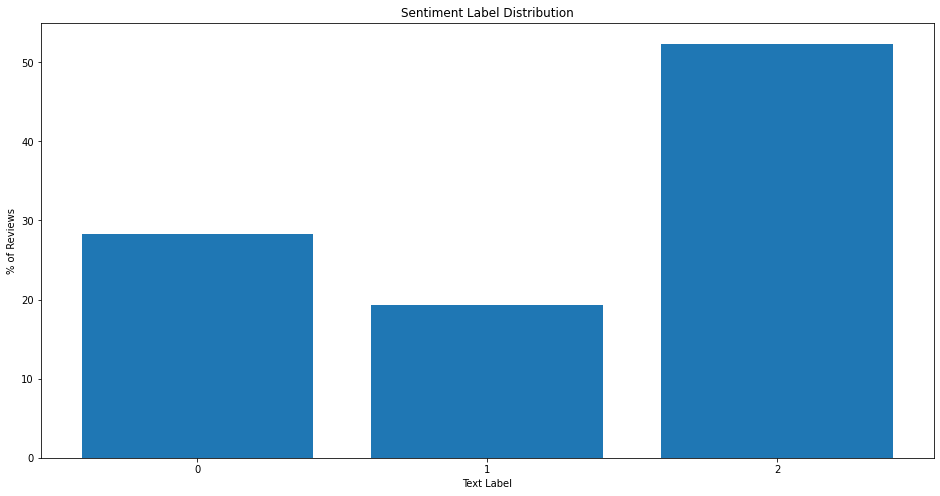

In [4]:
values, counts = np.unique(sentTrain['label'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure(figsize = (16,8))
plt.bar(values, normalized_counts*100)
plt.xlabel('Text Label')
plt.xticks([0,1,2])
plt.ylabel('% of Reviews')
plt.title("Sentiment Label Distribution")
plt.show()

In [5]:
X = sentTrain['text']
y = sentTrain['label']
sentWordsTrainVec = CountVectorizer(min_df = 50, stop_words='english')
sentWordsTrainVec.fit(X)
X_TrainVec = sentWordsTrainVec.transform(X)

X_test = sentTest['text']
y_test = sentTest['label']
sentWordsTestVec = CountVectorizer(min_df = 50, stop_words='english')
sentWordsTestVec.fit(X_test)
X_test = sentWordsTestVec.transform(X_test)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_TrainVec, y, test_size=0.25, random_state=12)

In [7]:
sentWordsDF = pd.DataFrame(columns = sentWordsTrainVec.get_feature_names(), data = X_train.toarray())
display(sentWordsDF)

,00,000,10,100,10000,10k,11,12,128,128gb,...,year,years,yelp,yes,yesterday,youtube,yum,yummy,zero,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def plot_most_frequent(words, word_counts, top=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()
    
    return words_df

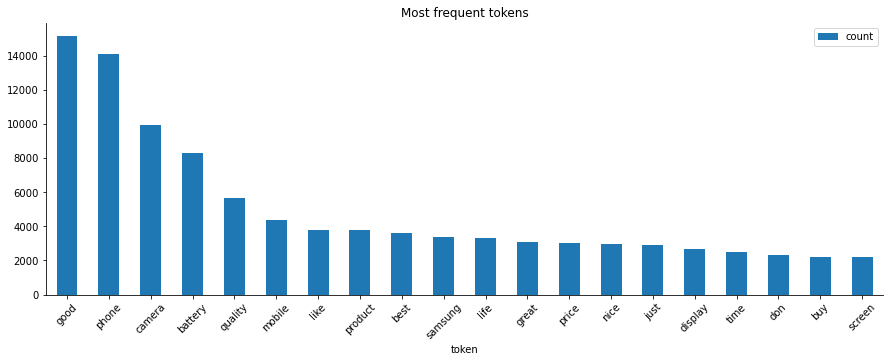

In [9]:
word_counts = X_train.toarray().sum(axis=0)
words = sentWordsTrainVec.get_feature_names()

wrodsDF = plot_most_frequent(words, word_counts)

In [10]:
%%time
valScores = []
trainScores = []
cVals = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    my_logreg = LogisticRegression(solver='lbfgs', C = c, random_state = 12)
    my_logreg.fit(X_train, y_train)
    
    trainScores.append(my_logreg.score(X_train, y_train))
    valScores.append(my_logreg.score(X_val, y_val))
    cVals.append(c)

Wall time: 12.6 s


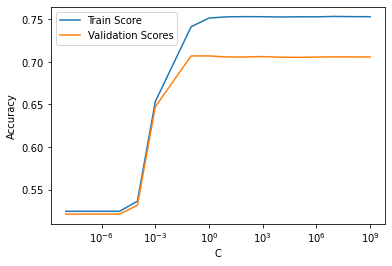

The c-calue with the highest valuation score is 0.1


In [11]:
plt.figure()
plt.plot(C_range, trainScores,label="Train Score")
plt.plot(C_range, valScores,label="Validation Scores")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-calue with the highest valuation score is {cVals[np.argmax(valScores)]}")

In [12]:
%%time
logit = LogisticRegression(solver='lbfgs', C = 0.1, random_state = 12)

logit.fit(X_train, y_train)
logit.score(X_val, y_val)

print(f"Logestical Regression Train: {logit.score(X_train, y_train)}")
print(f"Logestical Regression Valuation: {logit.score(X_val, y_val)}")
print(f"Logestical Regression Test: {logit.score(X_test, y_test)}")

Logestical Regression Train: 0.7412533333333333
Logestical Regression Valuation: 0.70696


ValueError: X has 411 features per sample; expecting 1673